In [ ]:
%matplotlib inline
import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading train data
path = '/content/drive/MyDrive/Capstone/train.csv'
train_df = pd.read_csv(path)
# Loading data data
path = '/content/drive/MyDrive/Capstone/test.csv'
test_df = pd.read_csv(path)


### Analysing the Risk Levels

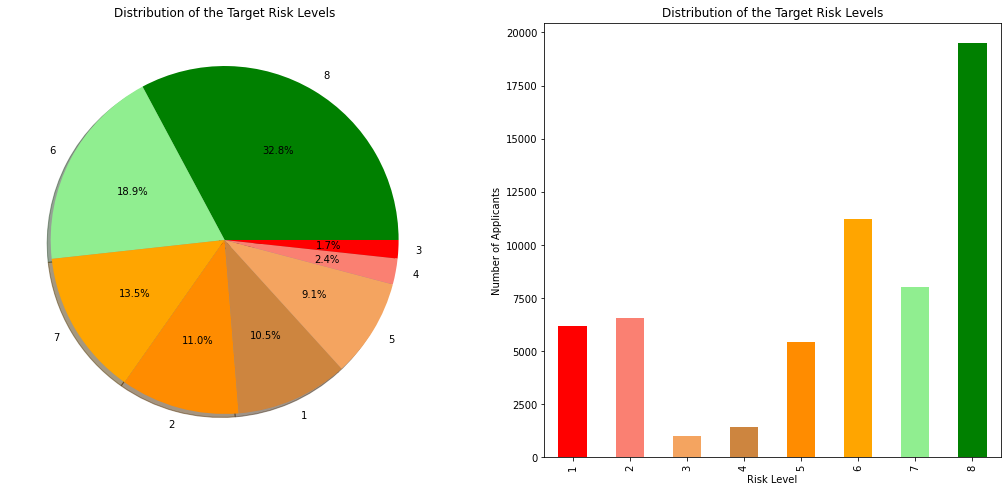

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train_df['Response'].value_counts().plot.pie(autopct='%1.1f%%',
                                            ax=ax[0],
                                            shadow=True,
                                            colors = ['green', 'lightgreen', 
                                                      'orange', 'darkorange', 
                                                      'peru', 'sandybrown', 
                                                      'salmon', 'red'])
ax[0].set_title('Distribution of the Target Risk Levels')
ax[0].set_ylabel('')
color_mapping ={1 : 'red', 
                2 : 'salmon', 
                3 : 'sandybrown', 
                4 : 'peru', 
                5 : 'darkorange',
                6 : 'orange',
                7 : 'lightgreen',
                8 : 'green'}
df_plot = pd.DataFrame(train_df['Response'].value_counts()).reset_index().sort_values(by='index')
df_plot.plot(kind='bar', x ='index', y='Response', 
             legend = False,
             xlabel = 'Risk Level', 
             ylabel = 'Number of Applicants',
             color = list(color_mapping.values()), ax=ax[1])
ax[1].set_title('Distribution of the Target Risk Levels')
plt.show()

The risk levels range from 0 to 8 where 0 denotes the highest risk and 8 determines the lowest risk. 

From the distribution plot, we can infer that
- The classes are imbalanced. 
- Low risk i.e Risk Level 8 has the highest number of applicants, which contributes to 32.8%.
- High risk i.e Risk Level 0 has 10.5% of the applicants.
- Risk Level 2 also around the same number of applicants as the highest risk i.e. 11%. 

Form the plots and target level segregation, to further find naunces we can group the same as:
- Low, medium and high risk.

We can also say that if the applicant falls under Risk Level 8, then for sure their application is approved as they fall under the lowest risk caterogy. This can help the insurers also have a combination of ML solution and Manual effort i.e. if the applicant has the lowest risk then the system can simply approve the insurance. Else, we further determine the actual risk level for further decide the premium price, etc mannualy. 

### Analysing Missing Data

In [ ]:
def missing_data(data):
    ''' Computes percentage missing data for each column. 
    Args: 
          data - DataFrame
    Returns:
          analysed_cols - Dataframe consisiting of total and percentage of 
                          Null values for each attribute
    '''
    total = data.isnull().sum()
    # Computing percentage missing data
    percent = (data.isnull().sum()/data.isnull().count()*100)
    analysed_cols = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return analysed_cols

In [ ]:
# Percentage missing train data for each attribute
missing_data(train_df)[['Percent']].sort_values(by='Percent', ascending=False)

,Percent
Medical_History_10,99.061990
Medical_History_32,98.135767
Medical_History_24,93.598963
Medical_History_15,75.101463
Family_Hist_5,70.411411
...,...
Medical_History_6,0.000000
Medical_History_5,0.000000
Medical_History_4,0.000000
Medical_History_3,0.000000


In [ ]:
# Percentage missing test data for each attribute
missing_data(test_df)[['Percent']].sort_values(by='Percent', ascending=False)

,Percent
Medical_History_10,98.983051
Medical_History_32,98.224134
Medical_History_24,94.029851
Medical_History_15,75.203643
Family_Hist_5,68.929927
...,...
Medical_History_6,0.000000
Medical_History_5,0.000000
Medical_History_4,0.000000
Medical_History_3,0.000000


By looking at the at missing values for both test and train, we see that few of the medical histrory related attributes are missing majority of the data. There are a total of 41 medical history attribues thus, we investigate futher by looking more closely at just the medical history related attributes:


In [ ]:
#Considering the Medical History Columns
med_cols = []
for i in range(1, 42):
  med_cols.append('Medical_History_'+str(i))
# Looking at the missing values considering the Medical History Columns 
missing_data(train_df[med_cols])[['Percent']].sort_values(by='Percent',ascending=False).head(8)

,Percent
Medical_History_10,99.061990
Medical_History_32,98.135767
Medical_History_24,93.598963
Medical_History_15,75.101463
Medical_History_1,14.969435
Medical_History_37,0.000000
Medical_History_36,0.000000
Medical_History_35,0.000000


By looking more closely at the Medical History columns it is clear that only 4 columns consist more than 50% null values. 

Medical History could be missing becuase of a number of reasons like this data was not collected for all applicants as it might have been deemed less important. The other possibility could be that that this data was based off on certain test or disease due to which it might be applicable to a very small population.

While modeling the data, we will exlpore the follwing
*   Imputing the missing values with zeros.
*   Dropping the columns.



### Analysing the Distribution of applicants based on Weight, Height, Height, BMI and Age

In [ ]:
def dist_plot(data, col, label_name):
  ''' Generates box plot and distribution plot for the desired column. 
    Args: 
          data - DataFrame 
          col - Attribute name
          label_name - Expanded attribute name 
  '''
  f, axes = plt.subplots(1, 2, figsize=(15,7))
  # Ploting distribution of the data for the given column using box plot and dist plot
  sns.boxplot(x = col , data=train_df, 
              orient='v', ax=axes[0]).set(xlabel = label_name)
  sns.distplot(train_df['Wt'],  ax=axes[1], axlabel= label_name)
  axes[0].title.set_text('Distribution of '+label_name)
  axes[1].title.set_text('Density Distribution of '+label_name)

In [ ]:
# Analysing outliers
def analyse_outliers(df_in, col_name):
    ''' Performs outlier Analysis by computing the Quartile values and 
    Inter Quartile values to analyse number of outliers and the distribution of 
    the risk levels among the outliers.   
    Args: 
          df_in - DataFrame consisting the data
          col_name - Attribute name
    '''
    print("Analysing the outliers for", col_name)
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    # Compute interquartile range
    iqr = q3-q1 
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    print("Minimum ", fence_low)
    print("Median  :", df_in[col_name].median())
    print("Maximum ", fence_high)
    df_out = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]
    print("Number of outliers below the minimum :",
          df_in.loc[(df_in[col_name] < fence_low)].shape[0])
    print("Number of outliers above the maximum :",
          df_in.loc[(df_in[col_name] > fence_high)].shape[0])
    print("Total number of outliers :", df_out.shape[0])
    print()
    if len(df_out)==0:
      return
    # Ploting distribution of the risk levels among the outliers.
    colors = ['green', 'lightgreen', 'orange', 'darkorange', 'peru', 'sandybrown', 'salmon', 'red']
    colors.reverse()
    df_plot = pd.DataFrame(df_out['Response'].value_counts()).reset_index()
    if len(df_plot<8):
      missing_label = set(range(1,9)).difference(set(df_plot['index']))
      for i in missing_label:
        df2 = pd.DataFrame([[i, 0]], columns=['index', 'response'])
        df_plot = pd.concat([df2, df_plot])
    df_plot = df_plot.sort_values(by='index')
    df_plot.plot(kind='bar', x ='index', y='Response', 
             legend = False,
             xlabel = 'Risk Level', 
             ylabel = 'Number of Applicants',
             color = colors,
             title = 'Distribution of Risk Level of the outliers based on '+ col_name)


#### Understanding distribution of Weight

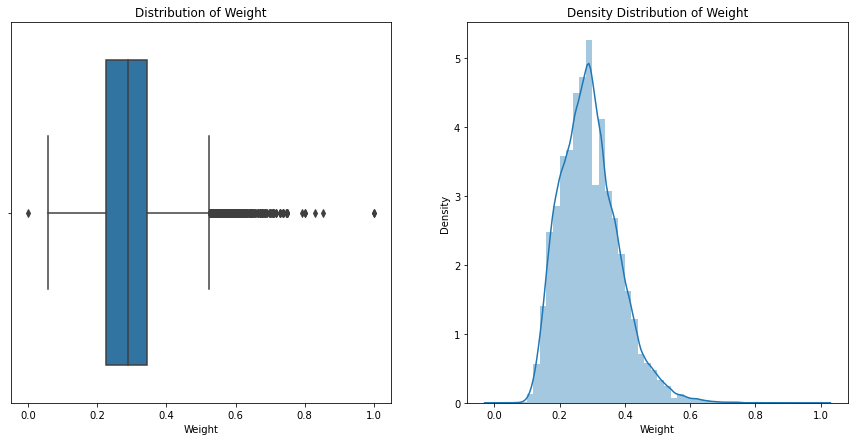

In [ ]:
dist_plot(train_df, 'Wt', 'Weight')

Analysing the outliers for Wt
Minimum  0.047071130000000044
Median  : 0.288702929
Maximum  0.524058578
Number of outliers below the minimum : 1
Number of outliers above the maximum : 853
Total number of outliers : 854



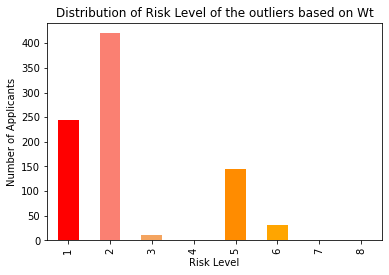

In [ ]:
analyse_outliers(train_df, 'Wt')

From the Distribution of weight it is seen that,
- The median weight is 0.28
- The density plot shows a narrow fit, and most of the points lie arounf the median.
- From the samples it is clear that majority of outlier samples lie in the high risks i.e. Risk Level 1 and 2, thus we would retain these outliers and not remove them.

#### Understanding distribution of Height

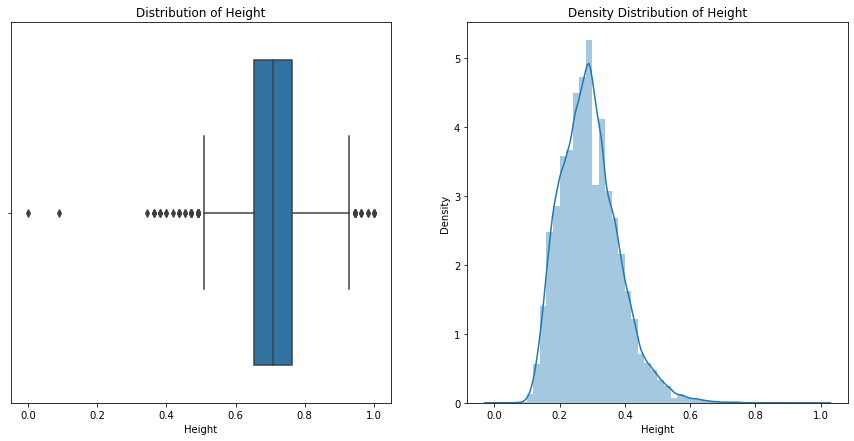

In [ ]:
dist_plot(train_df, 'Ht', 'Height')

Analysing the outliers for Ht
Minimum  0.4909090915000001
Median  : 0.709090909
Maximum  0.9272727274999999
Number of outliers below the minimum : 49
Number of outliers above the maximum : 23
Total number of outliers : 72



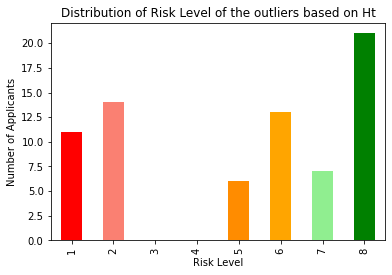

In [ ]:
analyse_outliers(train_df, 'Ht')

From the Distribution of height it is seen that,
- The median height is 0.70
- From the samples are spread out across lower risk and higher risk. 

#### Understanding distribution of BMI 

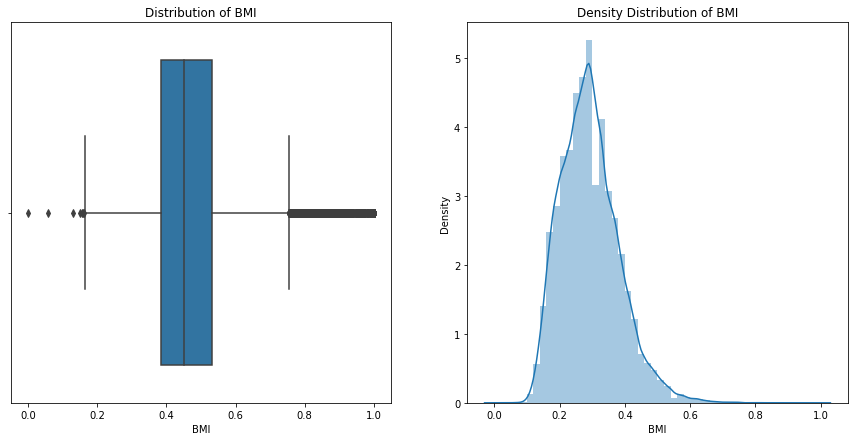

In [ ]:
dist_plot(train_df, 'BMI', 'BMI')

Analysing the outliers for BMI
Minimum  0.1645042030000001
Median  : 0.451349092
Maximum  0.7538703469999999
Number of outliers below the minimum : 7
Number of outliers above the maximum : 1627
Total number of outliers : 1634



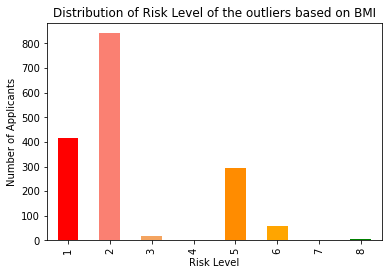

In [ ]:
analyse_outliers(train_df, 'BMI')

From the Distribution of BMI it is seen that,
- The median BMI is 0.45
- From the samples it is clear that majority of outlier samples lie in the high risks i.e. Risk Level 1 and 2, thus we would retain these outliers and not remove them.

#### Analysing the distribution of Age

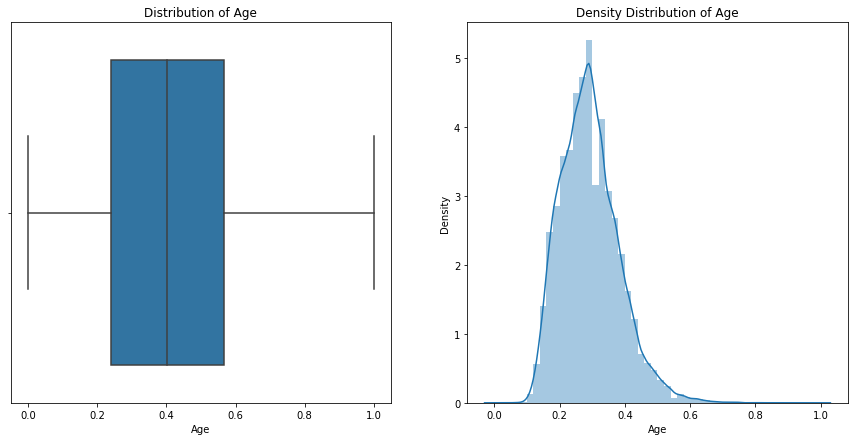

In [ ]:
dist_plot(train_df, 'Ins_Age', 'Age')

In [ ]:
analyse_outliers(train_df, 'Ins_Age')

Analysing the outliers for Ins_Age
Minimum  -0.25373134350000004
Median  : 0.402985075
Maximum  1.0597014925000001
Number of outliers below the minimum : 0
Number of outliers above the maximum : 0
Total number of outliers : 0



From the Distribution of Age it is seen that,
- The median age is around 0.4
- There are no outliers for the age attribute.

### Correlation Matrix 

In [ ]:
def plot_correlation_matrix(data, cols):
  ''' Generates correlation plot for the features. 
    Args: 
          data - DataFrame 
          col - list if Attribute name
  '''  
  corr = data[cols].corr()
  sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
  plt.show() 

#### We plot correlation matrix for subset of features 

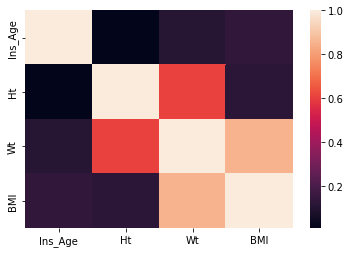

In [ ]:
cols = [ 'Ins_Age', 'Ht', 'Wt', 'BMI']
plot_correlation_matrix(train_df, cols)

From the above correlation matrix, it can be seen that Height-Weight abd BMI-Weight have a correlation greater than 0.6. This validates the intuition. 

Correlation of Medical Keyword


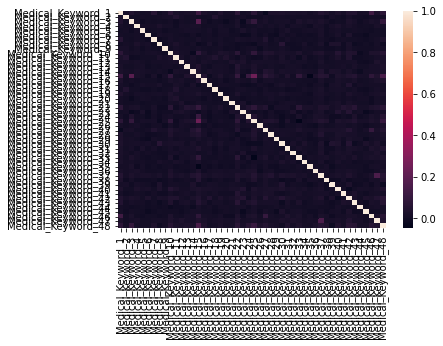

In [ ]:
print("Correlation of Medical Keyword")
col_names = []
for i in range(1,49):
  col_names.append('Medical_Keyword_'+str(i))
plot_correlation_matrix(train_df, col_names)

From the plot, we can figure that there are a few medical keywords that are related to each other and have a higher correlation metric. 

Correlation of Medical History


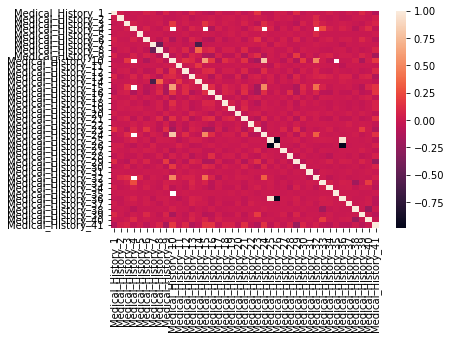

In [ ]:
print("Correlation of Medical History")
col_names = []
for i in range(1,42):
  col_names.append('Medical_History_'+str(i))
plot_correlation_matrix(train_df, col_names)

Majority of attributes related to Medical history have positive correlation, there are around 8 feature pairs that have the correlation of 1. 

Correlation of Product Info


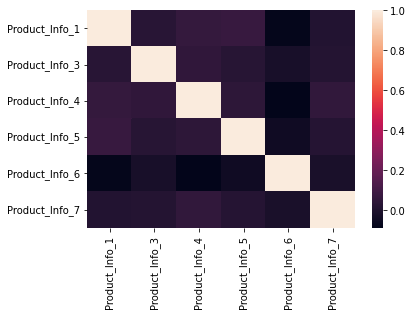

In [ ]:
print("Correlation of Product Info")
col_names = []
for i in range(1,8):
  col_names.append('Product_Info_'+str(i))
plot_correlation_matrix(train_df, col_names)

From the correaltion matrix it is clear that the product infos are not correlated to each other. 